# Praktikum 3, Monte Carlo

## Control variates

A control variate is a function, $h(x)$, that can be integrated analytically and is similar to the function, $f(x)$, that we want to integrate by a Monte Carlo method. We can test the method of control variates by using the autoconversion function studied earlier, $f(x|\alpha, \beta)$. For pedagogical purposes, suppose that the control variate is $h(x) = f(x|\alpha ′, \beta ′)$, where $\alpha ′ \approx α$ and $\beta ′ \approx \beta$. In other words, let’s pretend that we can’t integrate $f(x|\alpha, \beta)$ analytically, but that we can integrate $h(x) = f(x|\alpha ′, \beta ′)$ analytically. Then let’s use $h$ as a control variate.

The method of control variates is described in Section 8.9 of “Monte Carlo theory, methods and examples” by Art Owen. Following that reference, implement the method of control variates and test whether it produces less noise than basic Monte Carlo.

1. Implement $h$. Let $h$ be the autoconversion function, but instead of using the standard values, $\alpha = 2.47$ and $\beta = −1.79$, use $\alpha' = 2.2$ and $\beta' = −1.5$.

In [84]:
def f(chi, N_c, alpha=2.47, beta=-1.79):
    """Autoconversion.

    Autoconversion is the process by which small cloud droplets grow in size
    and become rain drops. Therefore, if there is more cloud water or larger
    drops, rain forms more easily.

    Args:
        chi (float): Cloud water mixing ratio.
        alpha (float): Often take to 2.47
        beta (float): Often take to -1.79
        N_c (float): Number of Cloud droplets.
    """
    from numpy import nan_to_num
    from numpy import power
    from numpy import heaviside
    return nan_to_num(heaviside(chi, 1) * np.power(chi, alpha) * power(N_c, beta))


def h(X, N_c):
    return f(X, N_c, alpha=2.2, beta=-1.5)

2. Overplot scatterplots of $f$ and $h$. Do they look correlated? To see better, overplot the line $y = x$. Calculate the sample correlation, $\rho$, between $f$ and $h$.

[[1.         0.99886496]
 [0.99886496 1.        ]]


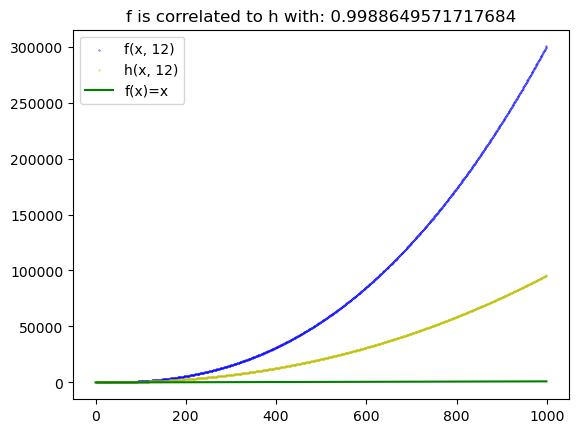

In [85]:
def plot_f_h(num_points=1000, N_c=12):
    from matplotlib import pyplot as plt
    import numpy as np
    x = np.arange(0, num_points, 1)
    f_x = f(chi=x, N_c=N_c)
    h_x = h(X=x, N_c=N_c)
    plt.scatter(x, f_x, label='f(x, 12)', s=0.1, c='b')
    plt.scatter(x, h_x, label='h(x, 12)', s=0.1, c='y')
    plt.plot(x, x, label='f(x)=x', c='g')
    plt.title(f'f is correlated to h with: {np.corrcoef(f_x, h_x)[0, 1]}')
    print(np.corrcoef(f_x, h_x))
    plt.legend()
    plt.show()


plot_f_h()

3. Write code to find the optimal value of the coefficient of the regression estimator, $\beta_{opt}$. To do so, calculate a sample estimate, $\hat{\beta}_{opt}$.

In [86]:
def calc_beta_opt(f_x, h_x):
    from numpy import corrcoef
    from numpy import var
    return corrcoef(f_x, h_x)[0, 1] / var(h_x)


N_c = 12
num_points = 1000
from numpy import arange

x = arange(0, num_points, 1)
beta_opt = calc_beta_opt(f(chi=x, N_c=N_c), h(X=x, N_c=N_c))
print(f'beta_opt for f and h is: {beta_opt}')

beta_opt for f and h is: 1.2468958518764257e-09


4. Use the regression estimator $\hat{\mu}_\beta$ to estimate $f$.

In [87]:
def calc_mu_beta(f, h, x, beta, theta, N_c=12):
    import numpy as np
    return (np.sum([f(chi=x_i, N_c=N_c) - beta * h(X=x_i, N_c=N_c) for x_i in x]) / n) + beta * theta

print(f'mu_beta for theta = 1: {calc_mu_beta(f, h, x, beta_opt, 1)}')

mu_beta for theta = 1: 86533.09753553872


In [88]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp

from scipy.stats import norm
from scipy.stats import pearsonr

In [89]:
def cholesky(sigma_x, sigma_y, r):
    import numpy as np
    assert r ** 2 <= 1
    L = np.zeros((2, 2))

    L[0, 0] = sigma_x
    L[1, 0] = r * sigma_y
    L[1, 1] = sigma_y * np.sqrt(1 - r ** 2)

    return L


def generate_X(value, sigma1, mu1, sigma2, mu2, r, seed1=None, seed2=None):
    import numpy as np
    from scipy.stats import norm
    np.random.seed(seed=seed1)
    randoms = np.random.rand(value)
    X = norm.ppf(randoms)

    np.random.seed(seed=seed2)
    randoms = np.random.rand(value)
    N_c = norm.ppf(randoms)

    Y = np.vstack((X, N_c))

    mu = np.array([[mu1], [mu2]])

    L = cholesky(sigma1, sigma2, r)

    X_ = L @ Y + mu

    lognormal = np.e ** X_[1]
    X_[1] = lognormal

    return X_


generate_X(10, 1, 0, 1, 0, 0.99, 1337, 42)

array([[-0.6371159 , -0.99988132, -0.58841609, -0.10215484, -0.46490278,
         0.04612031, -0.63736695,  1.97888078,  0.62134767, -1.19894726],
       [ 0.50871595,  0.46913499,  0.60942966,  0.93623955,  0.54724061,
         0.90758499,  0.4262968 ,  8.29343772,  1.91799521,  0.32966234]])

C:\Users\sberg\AppData\Local\Temp\ipykernel_8508\3410165489.py:17: RuntimeWarning: invalid value encountered in power
  return nan_to_num(heaviside(chi, 1) * power(chi, alpha) * power(N_c, beta))


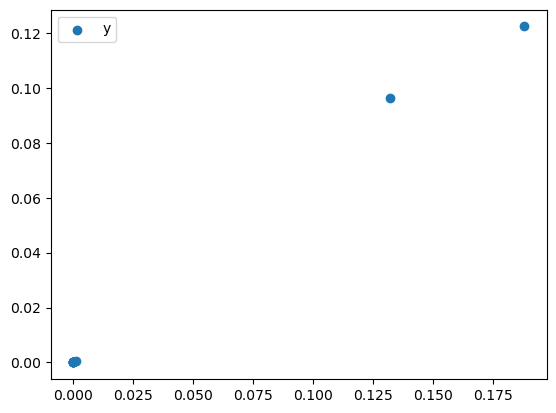

In [90]:
from matplotlib import pyplot as plt
import numpy as np

X = generate_X(value=10, sigma1=1, mu1=0, sigma2=1, mu2=0, r=0.99, seed1=1337, seed2=42)
y_h = np.array([h(X[0][i], X[1][i]) for i in range(X.shape[1])])
y_f = np.array([f(X[0][i], X[1][i]) for i in range(X.shape[1])])

plt.scatter(y_h, y_f, label="y")
plt.legend()
plt.show()

In [91]:
from scipy.stats import pearsonr

rho = pearsonr(y_h, y_f)
rho

PearsonRResult(statistic=0.9982200968092221, pvalue=4.3816297675771565e-11)

In [92]:
def beta(X):
    Chi = X[0]
    N = X[1]

    num = 0
    denum = 0

    f_quer = np.mean([f(Chi[i], N[i]) for i in range(Chi.shape[0])])
    h_quer = np.mean([h(Chi[i], N[i]) for i in range(Chi.shape[0])])

    # print(f_quer)
    # print(h_quer)

    for i, _ in enumerate(Chi):
        num += (f(Chi[i], N[i]) - f_quer) * (h(Chi[i], N[i]) - h_quer)
        denum += (h(Chi[i], N[i]) - h_quer) ** 2

    assert denum != 0

    return num / denum


X = generate_X(10, 1, 0, 1, 0, 0.99, 1337, 42)
print(X)
beta_head = beta(X)

f"beta_head: {beta_head}"

[[-0.6371159  -0.99988132 -0.58841609 -0.10215484 -0.46490278  0.04612031
  -0.63736695  1.97888078  0.62134767 -1.19894726]
 [ 0.50871595  0.46913499  0.60942966  0.93623955  0.54724061  0.90758499
   0.4262968   8.29343772  1.91799521  0.32966234]]


C:\Users\sberg\AppData\Local\Temp\ipykernel_8508\3410165489.py:17: RuntimeWarning: invalid value encountered in power
  return nan_to_num(heaviside(chi, 1) * power(chi, alpha) * power(N_c, beta))


'beta_head: 0.6752071535548988'

In [93]:
import math
import scipy as sp


def autoconversion_average(X, N_c, sigma_X, mu_X, sigma_N_c, mu_N_c, r, alpha=2.47, beta=-1.79):
    # sigma_X = np.sqrt(np.var(X))
    # sigma_N_c = np.sqrt(np.var(N_c))
    # mu_X = np.mean(X)
    # mu_N_c = np.mean(N_c)
    # r = np.correlate(X, N_c)[0]

    exp = np.e ** (mu_N_c * beta + 1 / 2 * sigma_N_c ** 2 * beta ** 2 - 1 / 4 * (
            mu_X / sigma_X + r * sigma_N_c * beta) ** 2)
    G = math.gamma(alpha + 1)

    v = - (alpha + 1)
    x = - (mu_X / sigma_X + r * sigma_N_c * beta)
    D, _ = sp.pbdv(v, x)

    return 1 / np.sqrt(2 * np.pi) * sigma_X ** alpha * exp * G * D


def theta(X, N_c, sigma_X, mu_X, sigma_N_c, mu_N_c, r):
    return autoconversion_average(X, N_c, sigma_X, mu_X, sigma_N_c, mu_N_c, r, alpha=2.2, beta=-1.5)

In [94]:
sigma_X = 1
sigma_N_c = 1
mu_X = 0
mu_N_c = 0
r = 0.99

X = generate_X(10, sigma_X, mu_X, sigma_N_c, mu_N_c, r, 1337, 42)


def mu_beta(X, beta, sigma_X, mu_X, sigma_N_c, mu_N_c, r):
    """calcululate mu beta

    Args:
        X (vector 2D): _description_
        beta (float): _description_
        sigma_X (float): _description_
        mu_X (float): _description_
        sigma_N_c (float): _description_
        mu_N_c (float): _description_
        r (float): _description_

    Returns:
        float: mu_beta
    """
    Chi = X[0]
    N = X[1]

    n = Chi.shape[0]
    result = 0

    for i, _ in enumerate(Chi):
        result += f(Chi[i], N[i])
        result -= beta * h(Chi[i], N[i])

    result /= n

    return result + beta * theta(Chi, N, sigma_X, mu_X, sigma_N_c, mu_N_c, r)

In [95]:
def monte_carlo(X, N_c):
    result = 0
    n = X.shape[0]
    for i in range(X.shape[0]):
        result += f(X[i], N_c[i])
    return result / n

In [96]:
n = 1000
sigma_X = 1
sigma_N_c = 1
mu_X = 0
mu_N_c = 0
r = 0.99

X = generate_X(n, sigma_X, mu_X, sigma_N_c, mu_N_c, r, 1337, 42)

In [97]:
sigma_X = 1
sigma_N_c = 1
mu_X = 0
mu_N_c = 0
r = 0.99
mu_error_list = []
mu_b_error_list = []
N = [500, 1000, 2000, 5000, 10000, 20000]
iterations = 10

for i in N:

    mu_error = 0
    mu_b_error = 0
    for j in range(iterations):
        X = generate_X(i, sigma_X, mu_X, sigma_N_c, mu_N_c, r)

        Chi = X[0]
        N_c = X[1]

        mu = monte_carlo(Chi, N_c)

        mu_b = mu_beta(X, beta(X), sigma_X, mu_X, sigma_N_c, mu_N_c, r)

        analytic = autoconversion_average(Chi, N_c, sigma_X, mu_X, sigma_N_c, mu_N_c, r)

        mu_error += np.abs(mu - analytic) / analytic
        mu_b_error += np.abs(mu_b - analytic) / analytic

        # print(f"mc: {mu}, mu_b: {mu_b}, beta: {beta(X)}, analytic: {analytic}")

    mu_error_list.append(mu_error / iterations)
    mu_b_error_list.append(mu_b_error / iterations)

plt.plot(np.log(N), np.log(mu_error_list), label="mc")
plt.plot(np.log(N), np.log(mu_b_error_list), label="mu_b_error")
plt.plot(np.log(N), np.log(1 / np.sqrt(N)), label="1/sqrt(N)")
plt.legend()
plt.show()

C:\Users\sberg\AppData\Local\Temp\ipykernel_8508\3410165489.py:17: RuntimeWarning: invalid value encountered in power
  return nan_to_num(heaviside(chi, 1) * power(chi, alpha) * power(N_c, beta))


AttributeError: Module 'scipy' has no attribute 'pbdv'

In [ ]:
1 - (np.array(mu_error_list) - np.array(mu_b_error_list)) ** 2

In [ ]:
X = generate_X(1000, sigma_X, mu_X, sigma_N_c, mu_N_c, r)
Chi = X[0]
Chi = np.where(Chi > 0, Chi, 0)
print(Chi)
N = X[1]

np.correlate(f(Chi, N), h(Chi, N))

In [ ]:
np.where(Chi > 0, Chi, 0)